# Sentiment Analysis on Yelp Open Dataset for Review Classification

Il Sentiment Analysis rappresenta uno dei tipi di Natural Language Processing più diffusi insieme alla Speech Recognition. Ciò che si intede fare all'interno del progetto è di studiare vari modelli di apprendimento per trovare un classificatore binario efficiente in grado di poter definire se una recensione Yelp sia positiva o negativa. Il progetto consisterà nello studio di un dataset open-source messo a disposizione da Yelp per scopi accademici, definirne le proprietà, manipolare i dati per prepararli all'addestramento di modelli, generare modelli secondo particolari strutture, salvarli e analizzarne i risultati.

### Import Libraries

Le librerie sono stati divisi per categorie, in base a come vengono utilizzati all'interno del notebook. Sono stati utilizzate funzioni basate su librerie classiche del ML come tensorflow e sklearn, per la gestione di manipolazione di testi come nltk e gensim, e metodi di analisi di dati forniti da seaborn, matplotlib e worldcloud.

In [11]:
# data collections
import pandas as pd
import numpy as np

# data analysis
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

# text manipulation
import gensim
from gensim.parsing.preprocessing import remove_stopwords
import nltk as nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# dataset manipulation
from collections import Counter, defaultdict
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# data modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


# save models
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/kode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data Loading

Uno dei primi ostacoli del progetto è stato il caricamento del dataset. Le sue dimensioni erano al più di 5 GB, questo significa che caricare direttamente tutto il file data poteva impiegare un uso non appropriato della memoria. Per risolvere questo problema, abbiamo diviso il file in blocchi o porzioni di dati con grandezza prefissata, in modo da allegerire il carico di caricamento in memoria e facilitare il lavoro della CPU. Per poter ottenere un procedimento performante, il processo prendeva in considerazione i tipi della struttura dati JSON, cosi da poter sapere a priori la quantità di byte da dover analizzare durante il caricamento. Alla fine del procedimento, i vari blocchi venivano unificati all'interno di un dataframe, una struttura dati messa a disposizione dalla libreria pandas di Python.

In [12]:
# definiamo i tipi degli attributi JSON per l'attributo dtype di read_json
rtypes = {  "review_id": str,
            "user_id":str,
            "business_id":str,
            "stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
            "text" : str,
           }

# file path del dataset json
path = './data/yelp_academic_dataset_review.json'

# grandezza dei chunk
chunkSize = 10000

In [13]:
%%time
# creazione del JsonReader
review = pd.read_json(path, lines=True,
                      orient="records",
                      dtype=rtypes,
                      chunksize=chunkSize)
chunkList = []

# utilizzo della segmentazione in chunk per creare dal JsonReader il dataframe
for chunkReview in review:
    # rimozione degli attributi id
    chunkReview = chunkReview.drop(['review_id', 'user_id','business_id'], axis=1)
    chunkList.append(chunkReview)
    
# concatenazione degli elementi nella chunkList per righe
df = pd.concat(chunkList, ignore_index=True, axis=0)

CPU times: user 1min 27s, sys: 14.3 s, total: 1min 41s
Wall time: 1min 42s


Mantenedo l'idea della divisione in blocchi, l'utilizzo della CPU e, in generale, del processo di caricamento dati, è stato ridotto fino a raggiungere 1 minuto e 42 secondi effettivi.

In [14]:
# visualizzazione degli elementi in testa
df.head()

,stars,useful,funny,cool,text,date
0,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


Il dataframe finale si presenta pien di informazioni ipoteticaente non utile agli scopi del progetto, tuttavia è stata presa in considerazione la scelta di analizzarne le proprietà totali per trovare possibili correlazioni con i campi principali e, nel caso vi siano, poterle sfruttare per la creazione dei modelli.

## 2. Data Analysis

Il data analysis raffigura uno dei procedimenti che ha lo scopo di dover rilevare proprietà nascoste sui dati in modo da poter capire a pieno la loro qualità e come poterla sfruttare al meglio per allenare i modelli. Successivamente, andremo a scansione i tipi di dati del dataframe andando ad analizzare campo per campo e trovare possibili informazioni utili per definire: distribuzione dei dati, tipi di dati, correlazioni o dipendenze con altri tipi di dato.

In [15]:
# informazioni sulle colonne del dataframe e su quante entries o righe si hanno
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8635403 entries, 0 to 8635402
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   stars   float16       
 1   useful  int32         
 2   funny   int32         
 3   cool    int32         
 4   text    object        
 5   date    datetime64[ns]
dtypes: datetime64[ns](1), float16(1), int32(3), object(1)
memory usage: 247.1+ MB


### 2.1 Stars Analysis

La feature "star" rappresenta uno dei tipi di dato più importanti dell'intero dataset. Rappresenta una valutazione numerica associata al testo di una reviews che, secondo la documentazione Yelp ufficiale, ha un dominio da 1 a 5. Dato che il nostro scopoo è quello di dover definire una classificazione binaria, andremo ad aggregare le classi in modo da distinguere se le valutazioni siano positive o negative; prima di ciò, dobbiamo analizzarne la struttura e capire come i valori siano distributiti all'internoo del dataset.

Text(0.5, 1.0, "Distribuzione dei valori per l'attributo stars")

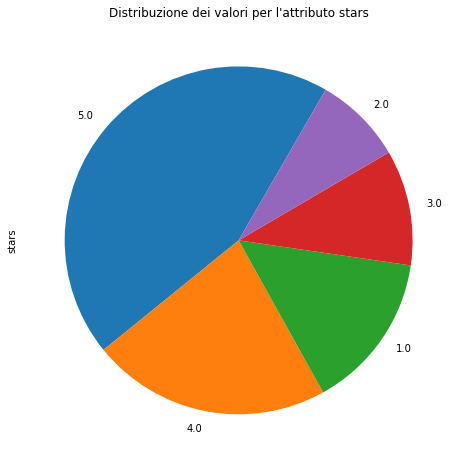

In [16]:
# definire la grandezza della figura
plt.figure(figsize=(8,8))

# contare i vari valori di stars e visualizzarli su un diagramma a torta
df['stars'].value_counts().plot.pie(startangle=60)

# definire il titolo del plot
plt.title('Distribuzione dei valori per l\'attributo stars')

Da come si può notare dal grafico precedente, le classi non sono bilanciate. La massima valutazione di "stars" rende attualmente impossibile dividere il dataset in due categorie opposte, per questo motivo, andremo a ribilanciare i valori andando a prendere un sottoinsieme di recensioni e dividerle tra training, validation e testing set. 

Text(0.5, 1.0, 'Distribuzione dei valori positivi e negativi')

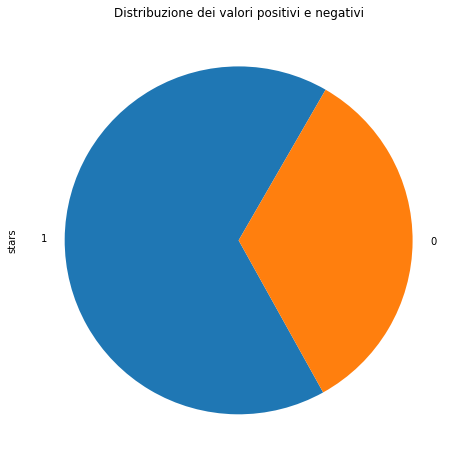

In [17]:
# distribuzione dei valori in reviews positive e negative
binstars = pd.DataFrame()
binstars['stars'] = [0 if star <= 3.0 else 1 for star in df['stars']]
# definire la grandezza della figura
plt.figure(figsize=(8,8))


# contare i vari valori di stars e visualizzarli su un diagramma a torta
binstars['stars'].value_counts().plot.pie(startangle=60)

# definire il titolo del plot
plt.title('Distribuzione dei valori positivi e negativi')

Come detto anche precedentemente, seguendo una divisione binaria in cui le valutazioni con valore superiore a 3 vadano classificate come "positive" mentre le restanti come "negative", non rende il dataset bilanciato. Da come si può notare dal grafico, le recensioni 1 (positive) hanno una quantità maggiore rispetto alle recensioni con valutazione 0 (negativa).

### 2.2 Cool, Fun and Useful Analysis

In [18]:
# Aggiunta di una feature per l'analisi della lunghezza dei testi
df['textLength']  = df['text'].str.len()

<AxesSubplot:>

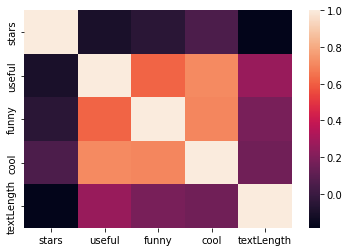

In [19]:
# definire le correlazioni
corr = df.corr()

# generazione dell'heatmap
sns.heatmap(corr)

Abbiamo tentato di trovare delle possibili correlazioni tra le proprietà dei campi di stars e di testo con le altre feature secondarie. Seguendo i risultati forniti dall'heatmap, non abbiamo tali correlazioni; quindi le feature secondarie non sono state giudicate utili nel raggiungere gli obiettivi del progetto.

### 2.3 Text Analysis

L'analisi sui testi è stata fondamentale per capire quali siano i termini utilizzati all'interno del vocabolario delle recensioni e come essi potevano essere classificati univocamente come una delle due categorie. L'obiettivo di tale sezione è quello di poter rendere noti quali siano i termini più utilizzati, se vi sia necessità di rimuovere alcuni termini fuorvianti, quali siano le parole più utilizzate e in quale forma.

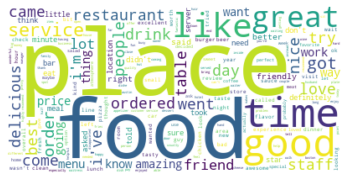

CPU times: user 19.9 s, sys: 748 ms, total: 20.7 s
Wall time: 20.6 s


In [20]:
%%time

# definisce un sottoinsieme delle righe del dataset
subset = df[:100000]
# concatenazione dei testi di ogni riga in una singola stringa
inputText = ' '.join(subset['text']).lower()

# creazione di un wordcloud andando ad ignorare le stopwords
wordCloud = WordCloud(background_color='white', stopwords=gensim.parsing.preprocessing.STOPWORDS).generate(inputText)
# setting della visualizzazione utilizzando una interpolazione bilineare
plt.imshow(wordCloud, interpolation='bilinear')

# rimozione degli assi
plt.axis('off')
# visualizzazione del wordcloud rappresentante le parole più usate nel testo di una recensione
plt.show()

Dato lo sbilanciamento del dataset verso le recensioni positive, era naturale aspettarci che termini positivi avrebbero avuto una frequenza maggiore rispetto a quelli negativi. Nello specifico, dal worldlcloud precedente, è possibile vedere termini come "good", "delicious" siano utilizzati più frequentemente per descrivere caratteristiche del servizio da recensire. Da parole come "food", "service", "place" o"restaurant", possiamo dedurre come la maggior parte delle recensioni siano collegate ad attività di ristorazione o culinarie. Da ciò, quindi, possiamo intuire già quali possa essere il vocabolario utilizzato ma, per maggior precisione, abbiamo deciso di poterne visualizzare i dati graficamente, cosi da poter avere una visione più precisa.

In [21]:
# calcolo della frequenza dei termini più utilizzati
wordTokens = word_tokenize(inputText)
tokens = list()
for word in wordTokens:
    if word.isalpha() and word not in gensim.parsing.preprocessing.STOPWORDS:
        tokens.append(word)
tokenDist = FreqDist(tokens)
# per questioni di visualizzazione, andiamo a prendere solamente i primi 20 termini utilizzati
dist = pd.DataFrame(tokenDist.most_common(20),columns=['term', 'freq'])

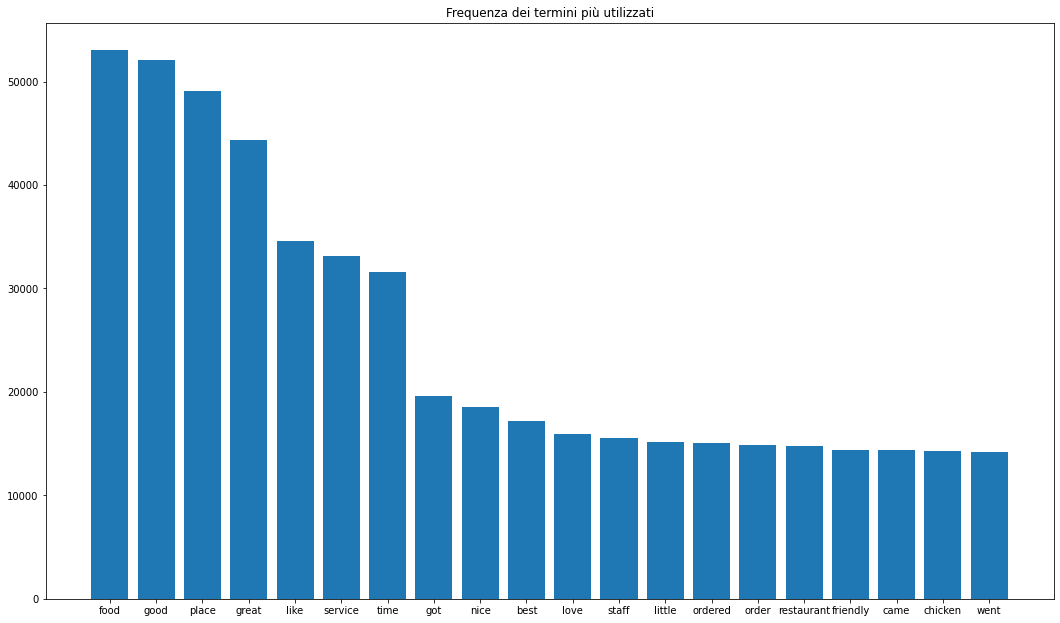

In [22]:
# rappresentazione grafica dei risultati
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x = dist['term']
y = dist['freq']
ax.bar(x,y)
plt.title('Frequenza dei termini più utilizzati')
plt.show()

L'analisi sui termini utilizzati all'interno di testi delle recensioni, ci fa notare come stopwords senza un significato concettuale non siano presenti tra le prime parole più frequenti. Ciò non toglie che dovremmmo eliminare per ridurre la varianza di termini utilizzati all'interno del dataset, questo perchè se la quantità di parole utilizzata è minore, è possibile ottenere un classificatore addestrato più velocemente e che tenga conto solamente delle parole chiavi piuttosto che sull'utilizzo di termini secondari e non rilevanti al fine della classificazione.

In [23]:
df.head()

,stars,useful,funny,cool,text,date,textLength
0,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,1856
1,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,701
2,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,578
3,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,390
4,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01,181


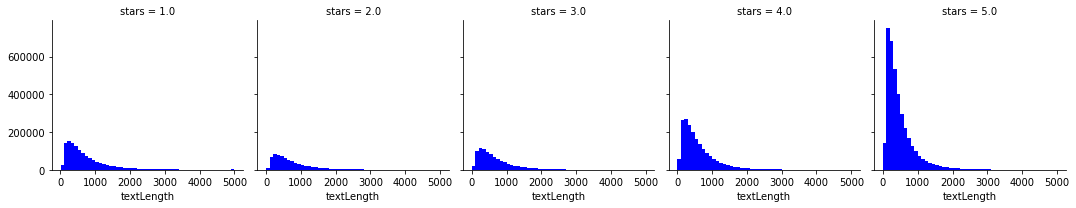

In [24]:
# Differenziazione della lunghezza dei testi in relazione alla valutazione data a stars
graph = sns.FacetGrid(data=df,col='stars')
graph.map(plt.hist,'textLength',bins=50,color='blue')

Un altra caratteristica che abbiamo notato, è stata l'omogeneità nella lunghezza delle recensioni. Normalizzando le curve dei grafici sull'asse della quantità, si puà notare come la distribuzione della lunghezza dei testi sia molto simile tra le recensioni con differente valutazione.

## 3. Data Pre-processing

La procedura di data manipulation per il pre-processamento dei dati, consisterà nell'effettuare una serie di modifiche sul dataset in modo da poterlo utilizzare in maniera più efficiente per le fasi di addestramento e di testing su modelli di classificazione. Nello specifico, andremo a rimuovere le feature non inutilizzate per gli obiettivi del progetto, i valori nulli e inconsistenti, ridurremo i testi nella stessa forma andando a diminuire tutti i caratteri nella loro forma minuscola e lemmatizzare le parole in modo da poter aggregare varie forme di uno stesso termine, rimuovere le stopwords (termini frequenti non rilevanti), rimozione dei caratteri non alfanumerici (segni di punteggiatura o caratteri speciali) e, infine, tokenizzazione di testi e polarizzazione delle valutazioni per la feature "star" in modo da ottenerne un dominio binario (0 e 1).

### 3.1 Rimozione features inutilizzate e valori nulli

In [25]:
# cancellazione delle caratteristiche cool, funny, useful e textLength poichè non hanno correlazioni con stars.
df = df.drop(['cool', 'funny', 'useful', 'textLength'], axis=1)

In [26]:
df.head()

,stars,text,date
0,4.0,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,4.0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,5.0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,2.0,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,4.0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [27]:
# rimozione di possibili testi vuoti
df['text'].dropna(inplace=True)

### 3.2 Riduzione dei testi in lowercase

Effettuando tale cambiamento, non vi sarà il rischio che i modelli possano classificare parole come "Hello" e "hello" poichè nella logica umana e grammaticale, rappresentano due forme di espressione di una stessa parola.

In [28]:
# ridurre la forma delle parole in minuscolo
df['text'] = [review_text.lower() for review_text in df['text']]

In [29]:
df['text'].head()

0    apparently prides osteria had a rough summer a...
1    this store is pretty good. not as great as wal...
2    i called wvm on the recommendation of a couple...
3    i've stayed at many marriott and renaissance m...
4    the food is always great here. the service fro...
Name: text, dtype: object

### 3.3 Polarizzazione dei labels (stars) e bilanciamento del dataset

Per allegerire il carico di lavoro associato alla trasformazione del dataset, abbiamo anticipato il pre-processing sulla polarizzazione dei valori di stars cosi da poter lavorare su un sottoinsieme bilanciato che, per realizzarlo, ha bisogno del selezionamento di recensioni appartenenti ad una delle due classi binarie nelle stesse quantità. 

In [118]:
# polarizzazione delle valutazioni a stars in due categorie: 1 = positiva, 0 = negativa

# isoliamo la colonna di testo del dataframe in texts
texts =  df['text']

# andiamo ad impostare negative tutte le recensioni con 3 o meno stelle e positive quelle con 4 e 5 stelle.
stars = [0 if star <= 3.0 else 1 for star in df['stars']]

balancedTexts = [] # rappresenta la collezione di testi presi in considerazione dal dataframe di input
balancedLabels = [] # rappresenta il nuovo valore polarizzato assegnato all'entry (0,1)

# andiamo a bilanciare il dataset andando a dividere recensioni positive e negative con limite di 1.000.000 per categoria
limit = 200000  

# posizione 0 per conteggio di recensioni negative, posizione 1 per quelle positive
negPosCounts = [0, 0] 

for i in range(0,len(texts)):
    polarity = stars[i]
    if negPosCounts[polarity] < limit: # se non si è raggiunto il limite per la categoria di polarizzazione
        balancedTexts.append(texts[i])
        balancedLabels.append(stars[i])
        negPosCounts[polarity] += 1

In [119]:
df_balanced = pd.DataFrame()
df_balanced['text'] = balancedTexts
df_balanced['labels'] = balancedLabels
df_balanced.head()

,text,labels
0,apparently prides osteria had a rough summer a...,1
1,this store is pretty good. not as great as wal...,1
2,i called wvm on the recommendation of a couple...,1
3,i've stayed at many marriott and renaissance m...,0
4,the food is always great here. the service fro...,1


In [120]:
# verifica del conteggio
counter = Counter(df_balanced['labels'])
print(f'Ci sono {counter[1]} recensioni positive e {counter[0]} recensioni negative')

Ci sono 200000 recensioni positive e 200000 recensioni negative


Come risultato del bilanciamento, abbiamo un dataset formato da 400.000 recensioni in cui il 50% sono positive e le restanti negative.

### 3.3 Lemmatizzazione

La lemmatizzazione prevede un procedimento oneroso sul dataset bilanciato. Nello specifico, andremo ad associare un tag semantico ad ogni parola in modo da differenziare quale tipo di termine si stia analizzando e, a secondo della classe semantica di appartenenza, effettuare una lemmatizzazione ad-hoc in modo da ottenere la corretta forma normalizzata.

In [121]:
%%time
# creazione del lemmatizer
lemmatizer = WordNetLemmatizer()

# funzione per l'aggiunta del tag semantico che evidenzia il tipo di parola da dover selezionare
def word_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None


# elaborazione sui testi del dataset
texts = df_balanced['text']

def lemmatize_reviews(texts):
    df_texts = []
    for text in texts:
        # tokenizzazione del text per l'aggiunta dei tag
        word_tagged = nltk.pos_tag(nltk.word_tokenize(text))
        # mapping parole:tag del testo analizzato
        map_word_tag = list(map(lambda x: (x[0], word_tagger(x[1])), word_tagged))
        # costruzione del testo lemmatizzato
        lemmatized_text = []
        for word, tag in map_word_tag:
            if tag is None:
                # elemento non tokenizzabile
                lemmatized_text.append(word)
            else:
                # lemmmatizzazione della parola in relazione al 
                # tipo di elemento
                lemmatized_text.append(lemmatizer.lemmatize(word, tag))
        # aggiunta della parola post-lemmatizzazione al testo selezionato
        lemmatized_text = " ".join(lemmatized_text)
        # aggiunta del testo nella collezione dei testi lemmatizzati
        df_texts.append(lemmatized_text)
    return df_texts
df_texts = lemmatize_reviews(texts)
print(texts[0] + "\n\n")
print(df_texts[0])

apparently prides osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a friday night. however new blood in the kitchen seems to have revitalized the food from other customers recent visits. waitstaff was warm but unobtrusive. by 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. perhaps beverly residents prefer a later seating. 

after reading the mixed reviews of late i was a little tentative over our choice but luckily there was nothing to worry about in the food department. we started with the fried dough, burrata and prosciutto which were all lovely. then although they don't offer half portions of pasta we each ordered the entree size and split them. we chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and grana frita. both were very good. we split a secondi which was the special berkshire pork secreto, which was described as a pork skirt steak with g

In [122]:
df_balanced['text'] = df_texts

### 3.4 Rimozione delle stop words e di caratteri non alfanumerici

Come insieme di stopwords, non è stato possibile utilizzare il set offerto da nltk poichè vi erano presenti termini di negazione che, per gli obiettivi del progetto, sono molto importanti per poter distinguere l'appartenenza di una classe di una recensione. Per risolvere tale problema, abbiamo utilizzato un insieme alternativo fornito dalla libreria gensim.

In [123]:
# Stop words da rimuovere
print(gensim.parsing.preprocessing.STOPWORDS)

frozenset({'co', 'indeed', 'eight', 'by', 'thick', 'nor', 'some', 'inc', 'ever', 'interest', 'whose', 'without', 'behind', 'computer', 'were', 'where', 'ours', 'else', 'in', 'yet', 'few', 'could', 'i', 'mine', 'go', 'him', 'however', 'still', 'nothing', 'forty', 'back', 'yourselves', 'throughout', 'otherwise', 'becomes', 'your', 'thus', 'per', 'give', 'up', 'couldnt', 'along', 'she', 'front', 'am', 'too', 'various', 'both', 'someone', 'anyone', 'on', 'them', 'so', 'becoming', 'latterly', 'since', 'own', 'together', 'same', 'during', 'which', 'full', 'hers', 'seemed', 'fifteen', 'nowhere', 'whereupon', 'thin', 'toward', 'serious', 'kg', 'bottom', 'from', 'don', 'while', 'first', 'unless', 'when', 'became', 'used', 'its', 'should', 'anyhow', 'everywhere', 'always', 'system', 'anywhere', 'and', 'had', 'call', 'now', 'been', 'neither', 'noone', 'among', 'empty', 'of', 'are', 'can', 'put', 'hereupon', 'hereby', 'may', 'fifty', 'or', 'because', 'above', 'others', 'much', 'sixty', 'does', 'mo

In [124]:
# Rimozione delle stop words
df_texts = []
for text in df_balanced['text']:
    df_texts.append(remove_stopwords(text))

df_balanced['text'] = df_texts

# Rimozione dei caratteri non alfanumerici
df_texts = []
for text in df_balanced['text']:
    df_texts.append(''.join(ch for ch in text if ch.isalnum() or ch == ' '))

df_balanced['text'] = df_texts

In [125]:
print(df_balanced['text'])

0         apparently pride osteria rough summer evidence...
1         store pretty good  great walmart  preferred  m...
2         wvm recommendation couple friend use past thin...
3         ve stay marriott renaissance marriott s huge d...
4         food great  service manager staff super  draw ...
                                ...                        
399995    m yelper guy deserve time  lesson car wash bus...
399996    finger nail use  weird place  felt uncomfortab...
399997    soon walk  re ask groupon  base information re...
399998    thing palate threeyearold  receive box valenti...
399999    know difference  tall straw   venti straw  tim...
Name: text, Length: 400000, dtype: object


### 3.5 Text Tokenization

La tokenizzazione di testi prevede semplicemente la trasformazione di un testo in una lista o sequenza ordinata di parole in modo da poter avere una indicizzazione di ogni termine all'interno di una struttura matriciale.

In [126]:
%%time
# tokenizzazione del testo andando a dividere le stringhe in una lista di lemmi
df_balanced['text'] = [nltk.word_tokenize(text) for text in df_balanced['text']]

CPU times: user 1min 28s, sys: 727 ms, total: 1min 29s
Wall time: 1min 29s


In [127]:
df_balanced['text']

0         [apparently, pride, osteria, rough, summer, ev...
1         [store, pretty, good, great, walmart, preferre...
2         [wvm, recommendation, couple, friend, use, pas...
3         [ve, stay, marriott, renaissance, marriott, s,...
4         [food, great, service, manager, staff, super, ...
                                ...                        
399995    [m, yelper, guy, deserve, time, lesson, car, w...
399996    [finger, nail, use, weird, place, felt, uncomf...
399997    [soon, walk, re, ask, groupon, base, informati...
399998    [thing, palate, threeyearold, receive, box, va...
399999    [know, difference, tall, straw, venti, straw, ...
Name: text, Length: 400000, dtype: object

### 3.6 Word Reviews Representation

Dato che i modelli predittivi e i classificatori lavorano su valori numerici, abbiamo bisogno di trasformare i nostri token letterali in valori numerici. Tali valori, rappresenteranno una identificazione nel campo dei numeri reali per i termini. Parole che inizialmente erano poste in varie forme, grazie alla lemmatizzazione, verranno classificate sotto un unico identificatore numerico, cosi facendo non solo si ridurrà la quantità di valori interi presenti all'interno di ogni recensione, ma si avrà anche una maggior precisione sulla percezione semantica dei testi e, di conseguenza, migliorare le prestazioni dei modelli.

In [128]:
# definire il numero di parole da passare all'oggetto Tokenizer
# bisogna analizzare la quantità di parole che si ha nel dataframe selezionato
map_terms = dict()
for text in df_balanced['text']:
    for word in text:
        if word not in map_terms:
            map_terms[word] = 1

print(f'There are {len(map_terms)} different words') # number of words

There are 202903 different words


In [129]:
%%time
# definizione di un tokenizer delle prime 15.000 parole più utilizzate
tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(df_balanced['text'])
# trasformazione della sequenza di lemmi in sequenze di interi in modo da valutare più velocemente le parole
sequences = tokenizer.texts_to_sequences(df_balanced['text'])
# Sequenze di massimo 200 unità. Se vi sono testi con sequenze più lunghe esse vengono troncate, altrimenti si avrà 
# un riempimenti di 0 per testi undersized.
text_sequence = pad_sequences(sequences, maxlen=300)
labels = np.array(df_balanced['labels'])

CPU times: user 22.8 s, sys: 316 ms, total: 23.1 s
Wall time: 23.2 s


In [130]:
# check parziale degli indici delle parole 
word_index = tokenizer.word_index
# prendiamo le prime 50 parole indicizzate
check = {key: value for key, value in word_index.items() if value <= 50}
print(check)

{'nt': 1, 's': 2, 'good': 3, 'food': 4, 'place': 5, 'time': 6, 'like': 7, 'great': 8, 'order': 9, 'come': 10, 'service': 11, 'try': 12, 've': 13, 'wait': 14, 'want': 15, 'look': 16, 'restaurant': 17, 'nice': 18, 'm': 19, 'love': 20, 'price': 21, 'ask': 22, 'know': 23, 'think': 24, 'tell': 25, 'eat': 26, 'day': 27, 'people': 28, 'staff': 29, 'experience': 30, 'best': 31, 'little': 32, 'drink': 33, 'work': 34, 'bad': 35, 'chicken': 36, 'table': 37, 'thing': 38, 'menu': 39, 'need': 40, 'minute': 41, 'pretty': 42, 'friendly': 43, 'taste': 44, 'way': 45, 'use': 46, 'definitely': 47, 'bar': 48, 'friend': 49, 'delicious': 50}


Il vettore dei valori numerici ha un dominio pari a 15.000 tipi parole differenti tra le 132.062 totali. Si andrà, quindi, a selezionare più di 1/10 delle parole presenti nelle reviews che, però, ha una rilevanza maggiore rispetto ai 9/10 date le occorrenze maggiori. Inoltre, la sequenza ordinata creata andrà a seguire l'ordine di occorenza dei termini all'interno dei testi di 300 parole (grandezza massima).

## 4. Modelling

In questa fase è possibile trovare modelli alternativi utilizzati oggigiorno nel campo NLP. Nello specifico, si propone una triplice alternativa che vede l'utilizzo di un modello basato su LSTM, un modello di convulational neural network che va a supporto di LSTM e, infine, un modello di LSTM bidirezionale. Possiamo affermare che tutti i modelli hanno raggiunto un livello di precisione accettabile; ciò non toglie che vi possano essere vari miglioramenti che possano incrementarne le prestazioni.

In [88]:
# checking sulle compile flags di tensorflow
print(tf.sysconfig.get_compile_flags())
print(tf.__version__)

['-I/usr/local/lib/python3.9/site-packages/tensorflow/include', '-D_GLIBCXX_USE_CXX11_ABI=0', '-DEIGEN_MAX_ALIGN_BYTES=64']
2.6.0


Uno degli elementi che prenderemo come parametro è F/F1-Score che misura l'accuratezza di un modello su un particolare insieme di dati (testing e validation set nel nostro caso) basandosi sui parametri di precisione e recall. Per calcolarlo basta dividere il doppio prodotto della precisione per il recall con la loro somma.

In [171]:
# gestione del callback
# creazione del F-Score sul validation e training set
class f1_score_callback(tf.keras.callbacks.Callback):

    def __init__(self, train, validation=None):
        super(f1_score_callback, self).__init__()
        self.validation = validation
        self.train = train

    # stampa dei valori di F1-Score alla fine di ogni epoch
    def on_epoch_end(self, epoch, logs={}):

        logs['f1_score_train'] = float('-inf')
        X_train, y_train = self.train[0], self.train[1]
        y_pred = (self.model.predict(X_train).ravel()>0.5)+0
        score = f1_score(y_train, y_pred)  

        if (self.validation):
            logs['f1_score_val'] = float('-inf')
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_val_pred = (self.model.predict(X_valid).ravel()>0.5) + 0
            val_score = f1_score(y_valid, y_val_pred)
            logs['f1_score_train'] = np.round(score, 5)
            logs['f1_score_val'] = np.round(val_score, 5)
        else:
            logs['f1_score_train'] = np.round(score, 5)

In [ ]:
# early stopping
es_acc_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1, verbose=0)
es_loss_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0)

In [193]:
# train and test splitting
x_train, x_test, y_train, y_test = train_test_split(text_sequence , labels ,random_state=520, test_size=0.33, shuffle=True)

# train and validation splitting
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.5, random_state=1)

In [194]:
print(len(x_train))
print(len(x_val))
print(len(x_test))

134000
134000
132000


### 4.1 LSTM

Il modello proposto è formato da uno strato LSTM che è costituito da diverse celle in grado di elaborate sequenzialmente. La prima cella prende un embedding input dallo strato precedente (parola vettorializzata), inizializza un hidden state e processa sul proprio input restituendo un input e un hidden state (informazioni sulla parola). Le celle successive utilizzeranno tale hidden state per calcolare l'output sulla parola di input. Dato che abbiamo impostato return_sequences a True, alla fine della computazione, andremo a prendere tutti gli hidden state che andranno ad essere ridimensionati e classificati nei layer successivi. 

In [219]:
# creazione di un modello sequenziale vuoto in cui aggiungere i vari layers
lstm = keras.Sequential([
    layers.Embedding(15000,128,input_length=300), # word embedding
    layers.LSTM(128,return_sequences = True,  dropout=0.2), # long-short-term-memory layer per l'acquisizione di informazioni
    layers.Flatten(), # flattering della matrice in un vettore
    layers.Dense(256, activation="relu"), # hidden states
    layers.Dense(1, activation="sigmoid") # output layer che restituisce il tipo di review
]); 

lstm.compile(
    loss='binary_crossentropy', # loss function
    optimizer='adam', # adam optimizer
    metrics=['accuracy']) # accuracy come metrica esplicita

lstm.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 300, 128)          1920000   
_________________________________________________________________
lstm_29 (LSTM)               (None, 300, 128)          131584    
_________________________________________________________________
flatten_14 (Flatten)         (None, 38400)             0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)               9830656   
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 257       
Total params: 11,882,497
Trainable params: 11,882,497
Non-trainable params: 0
_________________________________________________________________


In [220]:
results_lstm = lstm.fit(x_train, y_train, epochs=3, 
                              validation_data=(x_val, y_val), 
                              callbacks=[f1_score_callback(train=(x_train,y_train),validation=(x_val,y_val)), 
                                         es_acc_callback, es_loss_callback])

Epoch 1/3
4188/4188 [==============================] - 1113s 263ms/step - loss: 0.3187 - accuracy: 0.8612 - val_loss: 0.2900 - val_accuracy: 0.8773
Epoch 2/3
4188/4188 [==============================] - 1145s 273ms/step - loss: 0.2443 - accuracy: 0.8976 - val_loss: 0.2903 - val_accuracy: 0.8776
Epoch 3/3
4188/4188 [==============================] - 1118s 267ms/step - loss: 0.1854 - accuracy: 0.9246 - val_loss: 0.3309 - val_accuracy: 0.8719


In [221]:
lstm.evaluate(x_test, y_test)

4125/4125 [==============================] - 225s 55ms/step - loss: 0.3331 - accuracy: 0.8720


[0.33312979340553284, 0.8719696998596191]

modelLSTM.evaluate(xTest, yTest)

### 4.2 Convulational Neural Network

Le convulational neural network riescono a riconoscere patterns all'interno di immagini cosi da poter riconoscere, ad esempio, se un gatto si trovi in alto a destra o in basso a sinistra. All'interno di classificazioni come quelle del Sentiment Analysis, è possibile utilizzare la stessa tecnica di pattern matching andando a lavorare su informazioni testuali, ossia su sequenze di parole che, in genere, fanno parte di una delle classi del dataset (nel nostro caso positive o negative). Successivamente, tramite il pooling, è possibile aggregare tali sequenze indipendentemente dalla loro posizione e darli in input ai layer successivi.

In [215]:
cnn = keras.Sequential([
    layers.Embedding(15000,128,input_length=300), # word embedding
    layers.Conv1D(128, 2, activation="relu"), # convulational layer per il text pattern matching tra coppie di parole
    layers.Conv1D(128, 2, activation="relu"), # secondo convulational layer
    layers.MaxPooling1D(pool_size=8), # max pooling per l'aggregazione dei pattern
    layers.Dense(256, activation="relu"), # strato fortemente connesso
    layers.Flatten(), # flattering delle dimensioni da 2D a 1D
    layers.Dense(1, activation="sigmoid") # strato di output che ritorna l'immagine della sigmoid activation function
])


cnn.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])



cnn.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 300, 128)          1920000   
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 299, 128)          32896     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 298, 128)          32896     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 37, 128)           0         
_________________________________________________________________
dense_61 (Dense)             (None, 37, 256)           33024     
_________________________________________________________________
flatten_13 (Flatten)         (None, 9472)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)               

In [216]:
results_cnn = cnn.fit(x_train, y_train, epochs=3, 
                               validation_data=(x_val, y_val), 
                              callbacks=[f1_score_callback(train=(x_train,y_train),validation=(x_val,y_val)), 
                                         es_acc_callback, es_loss_callback], 
                              batch_size=67)

Epoch 1/3
2000/2000 [==============================] - 177s 88ms/step - loss: 0.3477 - accuracy: 0.8469 - val_loss: 0.3066 - val_accuracy: 0.8700
Epoch 2/3
2000/2000 [==============================] - 176s 88ms/step - loss: 0.2695 - accuracy: 0.8885 - val_loss: 0.3503 - val_accuracy: 0.8561
Epoch 3/3
2000/2000 [==============================] - 178s 89ms/step - loss: 0.2167 - accuracy: 0.9121 - val_loss: 0.3404 - val_accuracy: 0.8614


In [222]:
cnn.evaluate(x_test, y_test)

4125/4125 [==============================] - 30s 7ms/step - loss: 0.3433 - accuracy: 0.8609


[0.34329962730407715, 0.8609393835067749]

### 4.1.1 Modello basato con layer della Convulational Neural Network seguiti da LSTM

Dato che il modello LSTM è ottimo per la classificazione di testi andando a gestire sequenzialmente le informazioni e riutilizzarle tra parole, mentre il modello della convulational neural network è ottimo per associare blocchi di parole a pattern informativi presenti in una delle due classi, potremmo combinare i modelli in modo da ottenere sfruttare la convulational neural network per la features extractions, per poi utilizzare LSTM per definire una classificazione sequenziale in grado di fornire informazioni di correlazione tra le features e darle in input agli strati successivi.

In [223]:
# creazione di un modello sequenziale vuoto in cui aggiungere i vari layers
clstm = keras.Sequential([
    layers.Embedding(15000,128,input_length=300), # word embedding
    layers.Conv1D(128, 2, activation="relu"), # convulational layer per il text pattern matching tra coppie di parole
    layers.Conv1D(128, 2, activation="relu"), # secondo convulational layer
    layers.MaxPooling1D(pool_size=8), # max pooling per l'aggregazione dei pattern
    layers.LSTM(128,return_sequences = True,  dropout=0.2), # long-short-term-memory layer per l'acquisizione di informazioni
    layers.Flatten(), # flattering della matrice in un vettore
    layers.Dense(256, activation="relu"), # hidden states
    layers.Dense(1, activation="sigmoid") # output layer che restituisce il tipo di review
])


clstm.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy'])

clstm.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 300, 128)          1920000   
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 299, 128)          32896     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 298, 128)          32896     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 37, 128)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 37, 128)           131584    
_________________________________________________________________
flatten_15 (Flatten)         (None, 4736)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 256)             

In [224]:
results_clstm = clstm.fit(x_train, y_train, epochs=3, 
                              validation_data=(x_val, y_val), 
                              callbacks=[f1_score_callback(train=(x_train,y_train),validation=(x_val,y_val)), 
                                         es_acc_callback, es_loss_callback], 
                              batch_size=67)

Epoch 1/3
2000/2000 [==============================] - 285s 142ms/step - loss: 0.3407 - accuracy: 0.8485 - val_loss: 0.3024 - val_accuracy: 0.8686
Epoch 2/3
2000/2000 [==============================] - 314s 157ms/step - loss: 0.2638 - accuracy: 0.8889 - val_loss: 0.3042 - val_accuracy: 0.8680
Epoch 3/3
2000/2000 [==============================] - 304s 152ms/step - loss: 0.2142 - accuracy: 0.9128 - val_loss: 0.3268 - val_accuracy: 0.8639


In [225]:
clstm.evaluate(x_test, y_test)

4125/4125 [==============================] - 80s 19ms/step - loss: 0.3289 - accuracy: 0.8637


[0.32887187600135803, 0.8636817932128906]

### 4.3 Modello basato con layer della Convulational Neural Network seguita da biLSTM (LSTM bidirezionale)

Il modello proposto utilizza la stessa logica di features extractions precedente andando ad utilizzare una convulational neural network per rilevare informazioni ricorrenti che distinguono le reviews positive da quelle negative. La differenza risiede nella fase di classificazione, in cui si ha uno strato LSTM bidirezionale in cui le informazioni date dal convulational neural network su una particolare feature sono in date sia dalle feature precedenti, nelle celle del primo strato, che da quelle successive, nelle celle del secondo strato alle medesime posizioni. Alla fine, le informazioni computate andranno in input agli strati successivi.

In [284]:
bilstm= keras.Sequential([
    layers.Embedding(15000,128,input_length=300), # word embedding
    layers.Conv1D(128, 2, activation="relu"), # convulational layer per il text pattern matching tra coppie di parole
    layers.Conv1D(128, 2, activation="relu"), # secondo convulational layer
    layers.MaxPooling1D(pool_size=8), # max pooling per l'aggregazione dei pattern
    layers.Bidirectional(layers.LSTM(128,return_sequences = True,  dropout=0.2)), # long-short-term-memory layer per l'acquisizione di informazioni
    layers.Dense(256, activation="relu"), # hidden states
    layers.Flatten(), # flattering della matrice in un vettore
    layers.Dense(1, activation="sigmoid") # output layer che restituisce il tipo di review
])

bilstm.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

bilstm.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 300, 128)          1920000   
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 299, 128)          32896     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 298, 128)          32896     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 37, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 37, 256)           263168    
_________________________________________________________________
dense_69 (Dense)             (None, 37, 256)           65792     
_________________________________________________________________
flatten_17 (Flatten)         (None, 9472)            

In [285]:
results_bidlstm = bilstm.fit(x_train, y_train, epochs=3, 
                              validation_data=(x_val, y_val), 
                              callbacks=[f1_score_callback(train=(x_train,y_train),validation=(x_val,y_val)), 
                                         es_acc_callback, es_loss_callback], 
                              batch_size=67)

Epoch 1/3
  28/2000 [..............................] - ETA: 4:49 - loss: 0.6868 - accuracy: 0.5570

KeyboardInterrupt: 

In [228]:
bilstm.evaluate(x_test,y_test)

4125/4125 [==============================] - 104s 25ms/step - loss: 0.3561 - accuracy: 0.8595


[0.35607245564460754, 0.859499990940094]

## 5. Save Models

Data l'eccessiva tempo speso per l'addestramento dei modelli, abbiamo deciso di salvarli in file appositi utilizzando la libreria pickle di Python, cosi da poterli tenere sempre a disposizione per l'esecuzione di test futuri. Da come si può notare negli esempi, i classificatori non sono ottimali ma forniscono un buon strumento di supporto per poter definire se una recensione sia positiva o negativa.

In [231]:
import pickle

# salviamo il tokenizer e i modelli su file
with open("dump/tokenizer/keras_tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)

lstm.save("dump/model/yelp_lstm.hdf5")
cnn.save("dump/model/yelp_cnn.hdf5")
clstm.save("dump/model/yelp_clstm.hdf5")
bilstm.save("dump/model/yelp_bilstm.hdf5")


In [274]:
# classe per la definizione di esiti
def predict_conv(predictions):
    res = []
    for pred in predictions:
        if pred >= 0.5:
            res.append(1)
        else:
            res.append(0)
            
    return res   
predict_conv([0.8,0.4,0.5])

[1, 0, 1]

In [301]:
# carichiamo il tokenizer e il modello da file
with open("dump/tokenizer/keras_tokenizer.pickle", "rb") as f:
    tokenizer = pickle.load(f)

# caricamento dei modelli
lstm = load_model("dump/model/yelp_lstm.hdf5")
cnn = load_model("dump/model/yelp_cnn.hdf5")
clstm = load_model("dump/model/yelp_clstm.hdf5")
bilstm = load_model("dump/model/yelp_bilstm.hdf5")

# definiamo gli esempi su cui testare il modello
sample = df[:100].sample()
text_sample = np.array(sample.text)
print(text_sample)
# usiamo il tokenizer per creare sequenze di interi da dare al modello
sequences = tokenizer.texts_to_sequences(text_sample)
data_examples = pad_sequences(sequences, maxlen=300)

# effettuare le predizioni e stampare i risultati
predictions_lstm = lstm.predict(data_examples)
predictions_cnn = cnn.predict(data_examples)
predictions_clstm = clstm.predict(data_examples)
predictions_bid = bilstm.predict(data_examples)
print(f"Random review\n: {sample}")
print(f"Risultati LSTM:\n {predict(predictions_lstm)}\n\n")
print(f"Risultati Convulational Neural Network:\n {predict(predictions_cnn)}\n\n")
print(f"Risultati Convulational Neural Network concatenata a LSTM:\n {predict(predictions_clstm)}\n\n")
print(f"Risultati Convulational Neural Network concatenata a biLSTM:\n {predict(predictions_bid)}\n\n")

['this a great place to go to be social with a group.  i went yesterday and had to wait in line ten minutes just to get in, but no big deal, as the newest addition to kendall square the "new" factor of state park delivers on the hype and is worth the wait!\n\nthe place was packed but it somehow did not feel crowded and while we were only there for drinks i will be back for the southern food. \n\nthe bar tenders kept everyone happy in the crowded restaurant and with good juke box tunes, fun shuffle board and great decor all of the ingredients were primed for a fun fueled night. \n\nkudos to the female bartender for making me and my friends 8  moscow mules and one great dirty vodka martini.  the group all agreed - delicious, 8 for 8! \n\na raucous good time in the always fun and classy kendall square.  if you\'re bar hopping near inman and kendall save yourself the walk to central and crash the party at state park.']
Random review
:     stars                                              

## 6. Risultati Raggiunti

In questa sezione, andiamo a proporre una rappresentazione grafica dei risultati andando a rappresentare i parametri di valutazione delle performance presi in considerazione: accuracy, loss, e f-score. I risultati ad essere differenziati per modello e per epoche di addestramento.

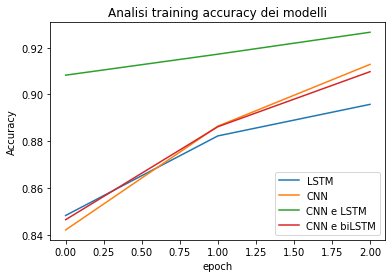

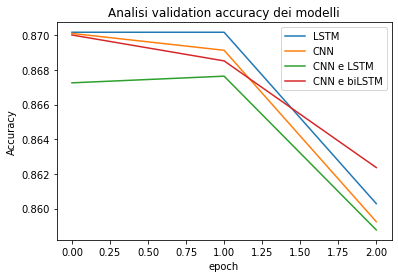

In [80]:
# grafico di paragone per i valori della training accuracy tra i modelli proposti
plt.plot(results_lstm.history['accuracy'])
plt.plot(results_cnn.history['accuracy'])
plt.plot(results_clstm.history['accuracy'])
plt.plot(results_bid.history['accuracy'])
plt.title('Analisi training accuracy dei modelli')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['LSTM', 'CNN', 'CNN e LSTM', 'CNN e biLSTM'], loc='best')
plt.show()


# grafico di paragone per i valori dell'accuracy in validazione
plt.plot(results_lstm.history['val_accuracy'])
plt.plot(results_cnn.history['val_accuracy'])
plt.plot(results_clstm.history['val_accuracy'])
plt.plot(results_bid.history['val_accuracy'])
plt.title('Analisi validation accuracy dei modelli')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['LSTM', 'CNN', 'CNN e LSTM', 'CNN e biLSTM'], loc='best')
plt.show()



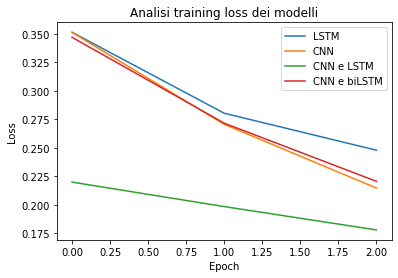

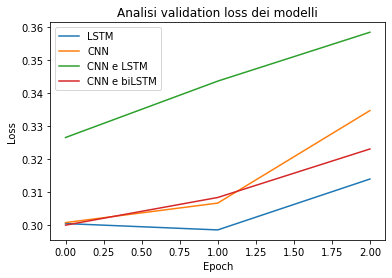

In [81]:
# grafico di paragone per i valori della loss function tra i modelli proposti
plt.plot(results_lstm.history['loss'])
plt.plot(results_cnn.history['loss'])
plt.plot(results_clstm.history['loss'])
plt.plot(results_bid.history['loss'])
plt.title('Analisi training loss dei modelli')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'CNN', 'CNN e LSTM', 'CNN e biLSTM'], loc='best')
plt.show()



# grafico di paragone per i valori della loss function tra i modelli proposti
plt.plot(results_lstm.history['val_loss'])
plt.plot(results_cnn.history['val_loss'])
plt.plot(results_clstm.history['val_loss'])
plt.plot(results_bid.history['val_loss'])
plt.title('Analisi validation loss dei modelli')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'CNN', 'CNN e LSTM', 'CNN e biLSTM'], loc='best')
plt.show()

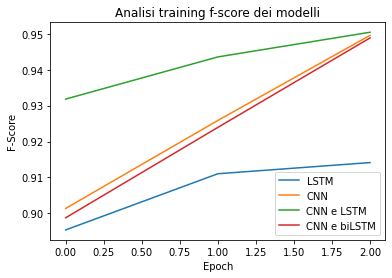

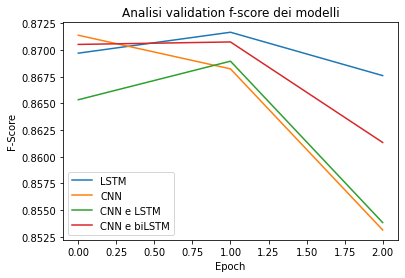

In [82]:
# grafico di paragone per i valori del F1-Score in validation

plt.plot(results_lstm.history['f1_score_train'])
plt.plot(results_cnn.history['f1_score_train'])
plt.plot(results_clstm.history['f1_score_train'])
plt.plot(results_bid.history['f1_score_train'])
plt.title('Analisi training f-score dei modelli')
plt.ylabel('F-Score')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'CNN', 'CNN e LSTM', 'CNN e biLSTM'], loc='best')
plt.show()

plt.plot(results_lstm.history['f1_score_val'])
plt.plot(results_cnn.history['f1_score_val'])
plt.plot(results_clstm.history['f1_score_val'])
plt.plot(results_bid.history['f1_score_val'])
plt.title('Analisi validation f-score dei modelli')
plt.ylabel('F-Score')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'CNN', 'CNN e LSTM', 'CNN e biLSTM'], loc='best')
plt.show()